In [15]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from astropy import cosmology
import matplotlib.pyplot as plt
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from autogalaxy.util import cosmology_util
from astropy import constants

cosmo = cosmology.Planck15

In [8]:
from autoconf import conf
import autofit as af
import autolens as al
import autolens.plot as aplt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib.colors import SymLogNorm
import re
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS

fig_path = '/Users/dgmt59/Documents/Plots/weak_lensing/'

In [9]:
workspace_path = "/Users/dgmt59/PycharmProjects/autolens_slacs/"
output_path = "/Users/dgmt59/output"
aggregator_results_path_1 = output_path + "/slacs_shu_bspline_clean/"
weak_data_path = "/Users/dgmt59/Documents/Data/slacs_weak_lensing/"
header_path = "/Users/dgmt59/Documents/Data/SLACS_headers/"

In [10]:
agg = af.Aggregator(directory=str(aggregator_results_path_1), completed_only=True)

Aggregator loading phases... could take some time.

 A total of 312 phases and results were found.


In [11]:
phase_name = "phase_4__mass_sie__source_inversion"

agg_shear_sie = agg.filter(agg.phase == phase_name,
                           agg.directory.contains("with_shear"),
                           agg.directory.contains("pix_voro_image__"))

print("Total Outputs = ",len(agg_shear_sie))

Filter found a total of 0 results
Total Outputs =  0


In [12]:
datasets_shear = agg_shear_sie.values("dataset")
outputs_shear = agg_shear_sie.values("samples")
instances_shear = [samps.median_pdf_instance for samps in agg_shear_sie.values("samples")]
lens_no = [re.sub('slacs', '', dataset.name) for dataset in datasets_shear]
ra_lens = [info["RA"] for info in agg_shear_sie.values("info")]
dec_lens = [info["DEC"] for info in agg_shear_sie.values("info")]
ra_dec = [ra[0:2]+' '+ra[2:4]+' '+ra[4:9]+' '+dec[0:3]+' '+dec[3:5]+' '+dec[5:9] for ra, dec in zip(ra_lens, dec_lens)]

In [13]:
radius = 1500 #in pixels
radius_deg = 0.0125

average_shear = []
average_angle = []
average_shear_north = []
average_angle_north = []
average_shear_deg = []
average_angle_deg = []

for lens, centre in zip(lens_no, ra_dec):
    weak_shear_data = fits.open(f"{weak_data_path}{lens}_F814W_drz_sci_clean.shears")
    data = weak_shear_data[1].data
    field_image_data  = get_pkg_data_filename(f"{weak_data_path}{lens}_F814W_drz_sci.fits")
    image = fits.open(field_image_data)[0]
    wcs = WCS(image.header)

    lens_centre = SkyCoord(centre, unit=(u.hourangle, u.deg))
    centre_pix = wcs.all_world2pix(lens_centre.ra.deg,lens_centre.dec.deg, 1)

    circle = plt.Circle((centre_pix[0], centre_pix[1]), radius, color='orange', fill=False)

    mask = np.full(len(data.x), True)

    pa = 0.5*np.arctan2(data.gamma2,data.gamma1)*(180/np.pi)
    pa_north_up= pa + 180 + image.header['ORIENTAT'] - 360
    total_gamma=np.sqrt(data.gamma1**2+data.gamma2**2)
    gamma1_north_up= total_gamma*np.cos(2*pa_north_up)
    gamma2_north_up= total_gamma*np.sin(2*pa_north_up)

    for i in range(len(data.x)):
        if ((data.x[i] - centre_pix[0])**2 + (data.y[i] - centre_pix[1])**2 > radius**2):
            mask[i] = False

    mask_deg = np.full(len(data.ra), True)
    for i in range(len(data.x)):
        if ((data.ra[i] - lens_centre.ra.deg)**2 + (data.dec[i] - lens_centre.dec.deg)**2 > radius_deg**2):
            mask_deg[i] = False

    g1 = []
    g2 = []
    g1_deg = []
    g2_deg = []
    g1_north = []
    g2_north = []
    x_inside = []
    y_inside = []

    for i in range(len(mask)):
        if mask[i]==True:
            g1_north.append(gamma1_north_up[i])
            g2_north.append(gamma2_north_up[i])
            g1.append(data.gamma1[i])
            g2.append(data.gamma2[i])
            x_inside.append(data.x[i])
            y_inside.append(data.y[i])

    for i in range(len(mask_deg)):
        if mask_deg[i]==True:
            g1_deg.append(data.gamma1[i])
            g2_deg.append(data.gamma2[i])

    mean_g1 = np.mean(g1)
    mean_g2 = np.mean(g2)
    mean_g1_deg = np.mean(g1_deg)
    mean_g2_deg = np.mean(g2_deg)
    mean_g1_north = np.mean(g1_north)
    mean_g2_north = np.mean(g2_north)

    shear = np.sqrt(mean_g1**2 + mean_g2**2)
    angle = 0.5*(np.arctan2(mean_g2,mean_g1))*(180/np.pi)
    shear_deg = np.sqrt(mean_g1_deg**2 + mean_g2_deg**2)
    angle_deg = 0.5*(np.arctan2(mean_g2_deg,mean_g1_deg))*(180/np.pi)
    shear_north = np.sqrt(mean_g1_north**2 + mean_g2_north**2)
    angle_north= 0.5*(np.arctan2(mean_g2_north,mean_g1_north))*(180/np.pi)

    average_shear.append(shear)
    average_angle.append(angle)
    average_shear_deg.append(shear_deg)
    average_angle_deg.append(angle_deg)
    average_shear_north.append(shear_north)
    average_angle_north.append(angle_north)

    fig = plt.figure(figsize=(15,15))
    plt.imshow(image.data, cmap='gray', norm=SymLogNorm(vmin=-0.13, vmax=20, linthresh=0.02))
    plt.scatter(data.x, data.y, edgecolors="cyan", marker="o", facecolors='none', s=80)
    plt.quiver(data.x,data.y,data.gamma1,data.gamma2)
    plt.scatter(x_inside, y_inside, edgecolors="orange", marker="o", facecolors='none', s=80)
    plt.gcf().gca().add_artist(circle)
    plt.savefig(f"{fig_path}{lens}.png")
    plt.close()


print(average_shear)
print(average_angle)
print(average_shear_deg)
print(average_angle_deg)

[]
[]
[]
[]


NameError: name 'np' is not defined

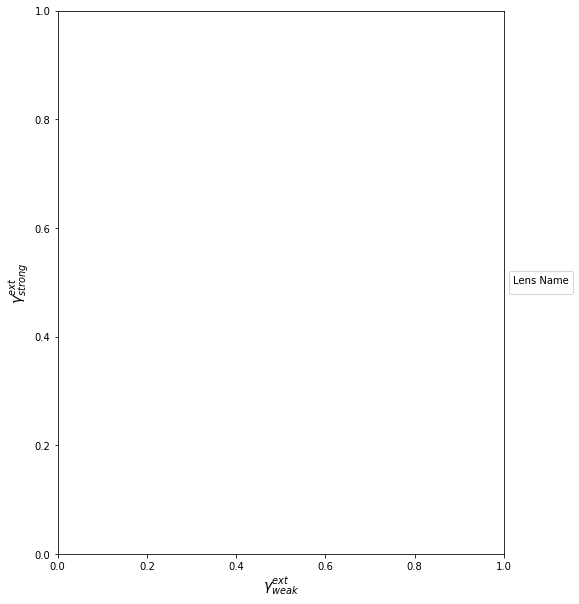

In [14]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset in zip(average_shear, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset")):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
plt.xlabel(r'$\gamma_{weak}^{ext}$', size=14)
plt.ylabel(r'$\gamma_{strong}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison.png", bbox_inches='tight', dpi=300)

In [ ]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset in zip(average_shear_deg, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset")):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
plt.xlabel(r'$\gamma_{weak}^{ext}$', size=14)
plt.ylabel(r'$\gamma_{strong}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison_degrees.png", bbox_inches='tight', dpi=300)


In [ ]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset in zip(average_shear_north, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset")):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
plt.xlabel(r'$\gamma_{weak}^{ext}$', size=14)
plt.ylabel(r'$\gamma_{strong}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison_north_up.png", bbox_inches='tight', dpi=300)


In [ ]:
pa_v3 = []
pa_other = []

for lens in lens_no:
    strong_header = fits.open(f"{header_path}SLACSJ{lens}_F814W_4_biz.fits")[0]
    pa_v3.append(strong_header.header["PA_V3"])
    pa_other.append(90-np.abs(strong_header.header["PA_V3"]-90))
print(len(pa_v3))

In [ ]:
pa_north = []

for instance in instances_shear:
    if instance.galaxies.lens.shear.phi < 90:
        pa_north.append(90 - instance.galaxies.lens.shear.phi)
    else:
        pa_north.append(-(instance.galaxies.lens.shear.phi-90))

print([180-np.abs(90-instance.galaxies.lens.shear.phi) for instance in instances_shear])
print([angle for angle in average_angle_north])
print([angle for angle in pa_north])

In [ ]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear, weak_angle, pa, info, instance, dataset in \
        zip(average_shear_north,
            average_angle_north,
            pa_north,
            agg_shear_sie.values("info"),
            instances_shear,
            agg_shear_sie.values("dataset")):
    ax1.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'])
    ax2.scatter(weak_angle, pa,
              color=info['colour'], marker=info['marker'], label=dataset.name)
ax1.set_xlabel(r'$\gamma_{weak}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{strong}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{weak}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{strong}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison.png", bbox_inches='tight', dpi=300)

In [ ]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear, weak_angle, pa, info, instance, dataset in \
        zip(average_shear,
            average_angle,
            pa_north,
            agg_shear_sie.values("info"),
            instances_shear,
            agg_shear_sie.values("dataset")):
    ax1.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'])
    ax2.scatter(weak_angle, pa,
              color=info['colour'], marker=info['marker'], label=dataset.name)
ax1.set_xlabel(r'$\gamma_{weak}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{strong}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{weak}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{strong}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison.png", bbox_inches='tight', dpi=300)


In [ ]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, weak_shear_north, dataset in zip(average_shear, agg_shear_sie.values("info"), average_shear_north, agg_shear_sie.values("dataset")):
    ax.scatter(weak_shear, weak_shear_north,
              color=info['colour'], marker=info['marker'], label=dataset.name)
plt.xlabel(r'$\gamma_{weak}^{x}$', size=14)
plt.ylabel(r'$\gamma_{weak}^{north}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}_weak_shear_comparison_diff_orientation.png", bbox_inches='tight', dpi=300)


In [ ]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, weak_shear_deg, dataset in zip(average_shear, agg_shear_sie.values("info"), average_shear_deg, agg_shear_sie.values("dataset")):
    ax.scatter(weak_shear, weak_shear_deg,
              color=info['colour'], marker=info['marker'], label=dataset.name)
plt.xlabel(r'$\gamma_{weak}^{pix}$', size=14)
plt.ylabel(r'$\gamma_{weak}^{deg}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}_weak_shear_comparison_diff_coords.png", bbox_inches='tight', dpi=300)